# Импорт библиотек

In [1]:
import warnings
import yaml
import math

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

warnings.filterwarnings('ignore')

# Описание задачи

В данном jupyter-ноутбуке мы произведем разведочный анализ данных

https://ods.ai/competitions/mtsmlcup

Задача соревнования
- Определение пола и возраста владельца HTTP cookie по истории активности пользователя в интернете на основе синтетических данных.

Метрики соревнования:
* ROC-AUC – для определения пола

Предобработка, аггрегация и создание новых фич произведена в 0.Data_preparing.ipng.
Описание колонок аггрегированного файла с данными:
* 'part_of_day_day' – кол-во визитов пользователя днем
* 'part_of_day_evening' – кол-во визитов пользователя вечером
* 'part_of_day_morning' – кол-во визитов пользователя утром
* 'part_of_day_night' – кол-во визитов пользователя ночью
* 'sum_visits' – кол-во визитов пользователя
* 'day_pct' – доля визитов пользователя днем
* 'evening_pct' – доля визитов пользователя вечером
* 'morning_pct' – доля визитов пользователя утром
* 'night_pct' – доля визитов пользователя ночью
* 'act_days' – кол-во дней, в которые пользователь совершил визит пользователя
* 'request_cnt' - кол-во запросов пользователя
* 'avg_req_per_day' - среднее кол-во запросов пользователя
* 'period_days' - кол-во дней между первым и последним визитом пользователя
* 'request_std' - стандартное отклонение по количеству запросов
* 'act_days_pct' - доля дней, когда пользователь совершал визит
* 'cpe_type_cd - тип устройства
* 'cpe_model_os_type' - операционная система устройства
* 'cpe_manufacturer_name' -производитель устройства
* 'price' - цена устройства пользователя
* 'region_cnt' - кол-во уникальных регионов, из которых был совершен визит
* 'city_cnt' - кол-во уникальных городов, из которых был совершен визит
* 'url_host_cnt' - кол-во уникальных ссылок, с которых был совершен визит
* 'user_id' – ID пользователя

Описание колонок файла с таргетами:

* 'age' – Возраст пользователя
* 'is_male' – Признак пользователя : мужчина (1-Да, 0-Нет)
* 'user_id' – ID пользователя

# Загрузка данных

In [42]:
config_path = '../config/parameters.yaml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

agg_data_path = config['preprocessing']['agg_data_path']
targets_path = config['train']['target_data_path']

In [3]:
# загружаем таргеты 
targets = pd.read_parquet(targets_path)
targets.head(3)

,age,is_male,user_id
350459,31.0,1,350459
188276,35.0,1,188276
99002,41.0,0,99002


In [4]:
# удалим пустые значения в таргете
targets = targets.query('is_male != "NA"').dropna()

In [5]:
# загружаем данные с признаками
df = pd.read_csv(agg_data_path)
df.head(3)

,user_id,part_of_day_day,part_of_day_evening,part_of_day_morning,part_of_day_night,sum_visits,day_pct,evening_pct,morning_pct,night_pct,...,avg_req_per_day,period_days,act_days_pct,cpe_type_cd,cpe_manufacturer_name,cpe_model_os_type,price,region_cnt,city_cnt,url_host_cnt
0,13,467,447,411,226,1551,0.301096,0.288201,0.264990,0.145712,...,30.681416,116,0.974138,smartphone,BQ Devices Limited,Android,-999.0,1,1,83
1,41,7,13,9,9,38,0.184211,0.342105,0.236842,0.236842,...,21.000000,4,1.000000,smartphone,Xiaomi,Android,12343.0,1,3,15
2,69,457,346,314,30,1147,0.398431,0.301656,0.273758,0.026155,...,37.392857,60,0.933333,smartphone,Apple,iOS,16657.0,1,1,91


In [6]:
train_data = df.merge(targets.drop('age', axis=1), on='user_id')

In [7]:
# проверим, есть ли пропуски в датасете
train_data.isna().sum()

user_id                  0
part_of_day_day          0
part_of_day_evening      0
part_of_day_morning      0
part_of_day_night        0
sum_visits               0
day_pct                  0
evening_pct              0
morning_pct              0
night_pct                0
act_days                 0
request_cnt              0
avg_req_per_day          0
period_days              0
act_days_pct             0
cpe_type_cd              0
cpe_manufacturer_name    0
cpe_model_os_type        0
price                    0
region_cnt               0
city_cnt                 0
url_host_cnt             0
is_male                  0
dtype: int64

In [8]:
config['preprocessing']['agg_columns_type']

{'is_male': 'int8',
 'user_id': 'int32',
 'part_of_day_day': 'int16,',
 'part_of_day_evening': 'int16',
 'part_of_day_morning': 'int16',
 'part_of_day_night': 'int16',
 'sum_visits': 'int16',
 'day_pct': 'float32',
 'evening_pct': 'float32',
 'morning_pct': 'float32',
 'night_pct': 'float32',
 'act_days': 'int16',
 'request_cnt': 'int32',
 'avg_req_per_day': 'float32',
 'period_days': 'int16',
 'act_days_pct': 'float32',
 'cpe_type_cd': 'category',
 'cpe_model_os_type': 'category',
 'cpe_manufacturer_name': 'category',
 'price': 'float32',
 'region_cnt': 'int8',
 'city_cnt': 'int8',
 'url_host_cnt': 'int16'}

In [9]:
# поменяем типы данных для экономии памяти
train_data = train_data.astype(config['preprocessing']['agg_columns_type'])

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264325 entries, 0 to 264324
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   user_id                264325 non-null  int32   
 1   part_of_day_day        264325 non-null  int16   
 2   part_of_day_evening    264325 non-null  int16   
 3   part_of_day_morning    264325 non-null  int16   
 4   part_of_day_night      264325 non-null  int16   
 5   sum_visits             264325 non-null  int16   
 6   day_pct                264325 non-null  float32 
 7   evening_pct            264325 non-null  float32 
 8   morning_pct            264325 non-null  float32 
 9   night_pct              264325 non-null  float32 
 10  act_days               264325 non-null  int16   
 11  request_cnt            264325 non-null  int32   
 12  avg_req_per_day        264325 non-null  float32 
 13  period_days            264325 non-null  int16   
 14  act_days_pct        

In [11]:
train_data.describe(include=['category'])

,cpe_type_cd,cpe_manufacturer_name,cpe_model_os_type
count,264325,264325,264325
unique,4,32,2
top,smartphone,Apple,Android
freq,264080,84721,179604


In [12]:
train_data.drop('user_id', axis=1).describe()

,part_of_day_day,part_of_day_evening,part_of_day_morning,part_of_day_night,sum_visits,day_pct,evening_pct,morning_pct,night_pct,act_days,request_cnt,avg_req_per_day,period_days,act_days_pct,price,region_cnt,city_cnt,url_host_cnt,is_male
count,264325.000000,264325.000000,264325.000000,264325.000000,264325.000000,264325.000000,264325.000000,264325.000000,264325.000000,264325.000000,264325.000000,264325.000000,264325.000000,264325.000000,264325.000000,264325.000000,264325.000000,264325.000000,264325.000000
mean,259.988741,233.253041,206.503551,82.773699,782.519031,0.359325,0.284020,0.267331,0.089325,31.301704,1350.046072,37.359093,40.281672,0.780143,27903.644531,1.789721,3.114132,77.917446,0.511987
std,339.628303,326.517844,285.779448,155.715933,1038.883702,0.161477,0.145328,0.147182,0.097314,28.206004,1902.770146,32.252926,31.599978,0.242543,24376.060547,1.639011,3.925372,70.374407,0.499857
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.016667,-999.000000,1.000000,1.000000,1.000000,0.000000
25%,36.000000,26.000000,25.000000,3.000000,106.000000,0.275591,0.217617,0.192090,0.014019,9.000000,157.000000,14.000000,15.000000,0.666667,11410.000000,1.000000,1.000000,28.000000,0.000000
50%,143.000000,117.000000,106.000000,25.000000,423.000000,0.337912,0.290283,0.260209,0.066929,24.000000,676.000000,28.894737,35.000000,0.875000,18271.000000,1.000000,2.000000,60.000000,1.000000
75%,356.000000,314.000000,277.000000,95.000000,1061.000000,0.420290,0.348837,0.325773,0.135359,47.000000,1787.000000,51.387386,58.000000,0.960784,40403.000000,2.000000,4.000000,107.000000,1.000000
max,6447.000000,7573.000000,5893.000000,5568.000000,23792.000000,1.000000,1.000000,1.000000,1.000000,181.000000,46941.000000,529.000000,181.000000,1.000000,195657.000000,36.000000,124.000000,1642.000000,1.000000


Вывод: минимальное значение цены -999, это заполненные нами пропуски несуществующим значением

# EDA

Рассмотрим соотношение классов в наших данных

In [13]:
target_feature = config['train']['target']

is_male
1    135331
0    128994
Name: count, dtype: int64


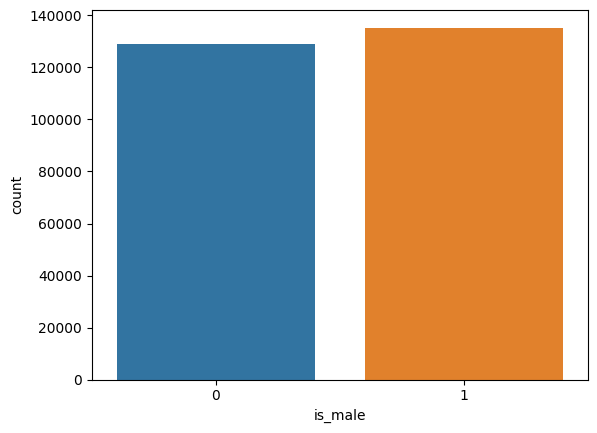

In [14]:
print(train_data[target_feature].value_counts())
sns.countplot(data=train_data, x=target_feature);

Вывод: соотношение классов в датасете добовально хорошо сбалансированно

In [15]:
def barplot_group(df: pd.DataFrame, col_main: str, col_group: str,
                  title: str) -> None:
    """
    Построение barplot с нормированными данными с выводом значений на графике
    """

    plt.figure(figsize=(18, 6))

    data = (df.groupby(
        [col_group])[col_main].value_counts(normalize=True).rename(
            'percentage').mul(100).reset_index().sort_values(col_group))

    ax = sns.barplot(x=col_main,
                     y="percentage",
                     hue=col_group,
                     data=data,
                     palette='rocket')

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
            ha='center',  # центрирование
            va='center',
            xytext=(0, 7),
            textcoords='offset points',  # точка смещения относительно координаты
            fontsize=12)

    plt.title(title, fontsize=16)
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel(col_main, fontsize=14)
    plt.show()

In [52]:
def displot_category(data: pd.DataFrame, cat_feature: str,
                     distribution_feature: str, 
                     plot_title: str,
                     limit: int = 0) -> None:
    """Построение displot с разбивкой по группам"""

    values_dict = {}
    for i in data[cat_feature].unique():
        values_dict[str(i)] = i
        
    if limit:
        data = data[data[distribution_feature] < limit]
        
    sns.displot(
        {
            k: data[data[cat_feature] == v][distribution_feature]
            for k, v in values_dict.items()
        },
        kind="kde",
        common_norm=False,
        height=6,
        aspect=2.1)

    plt.title(plot_title, fontsize=16)

    plt.xlabel(distribution_feature, fontsize=14)
    plt.ylabel('Density', fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.show()

In [17]:
def boxplot_category(data: pd.DataFrame, cat_feature: str,
                     distribution_feature: str, plot_title: str) -> None:
    plt.figure(figsize=(15, 10))
    sns.boxplot(data=data, 
                x=cat_feature, 
                y=distribution_feature)
    
    
    plt.title(plot_title, fontsize=16)
    plt.xlabel(cat_feature, fontsize=14)
    plt.ylabel(distribution_feature, fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

## Гипотеза 1
Среди пользователей Android больше мужчин, среди пользователей iOS - женщин

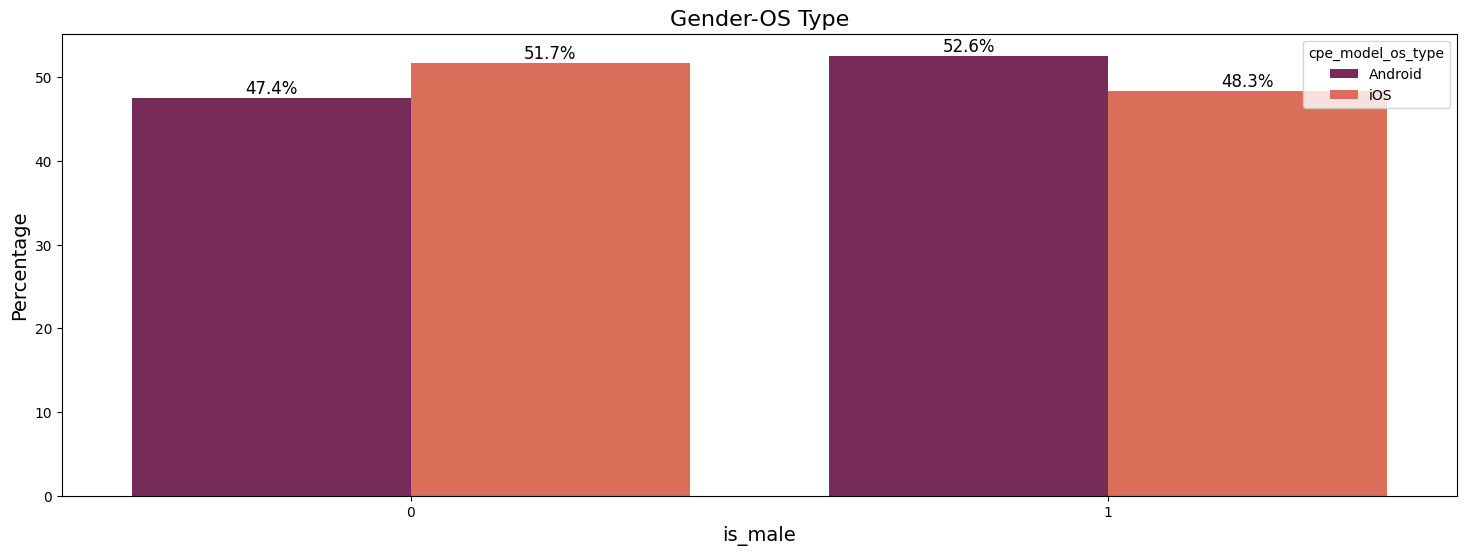

In [19]:
barplot_group(train_data, 'is_male', 'cpe_model_os_type', 'Gender-OS Type')

Вывод: среди пользователей Android небольшой перевес в соотношении в пользу мужчин, среди пользователей iOS - в пользу женщин

## Гипотеза 2
Среди пользователей смартфонов и планшетов больше женщин, в другие категориях наоборот

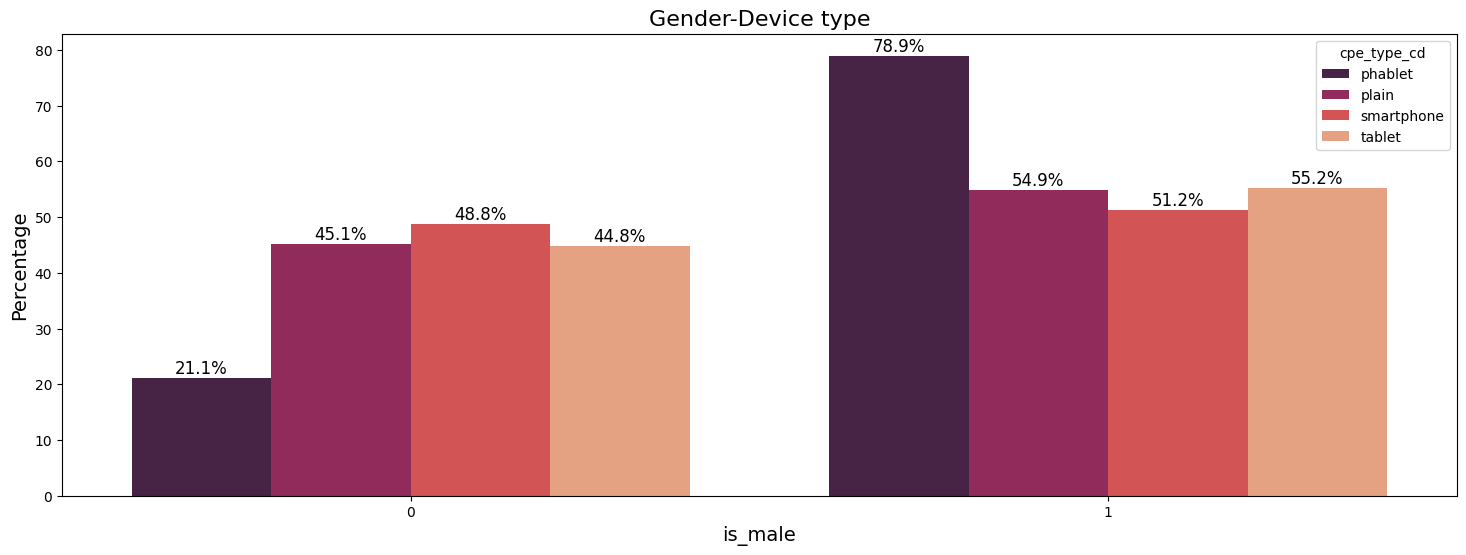

In [20]:
barplot_group(train_data, 'is_male', 'cpe_type_cd', 'Gender-Device type')

Вывод: 79% пользователей phablet - мужчины, в остальных категориях соотношение примерно равное с небольшим перевесом в пользу мужчин

## Гипотеза 3
Женщины чаще покупают более дорогие телефоны

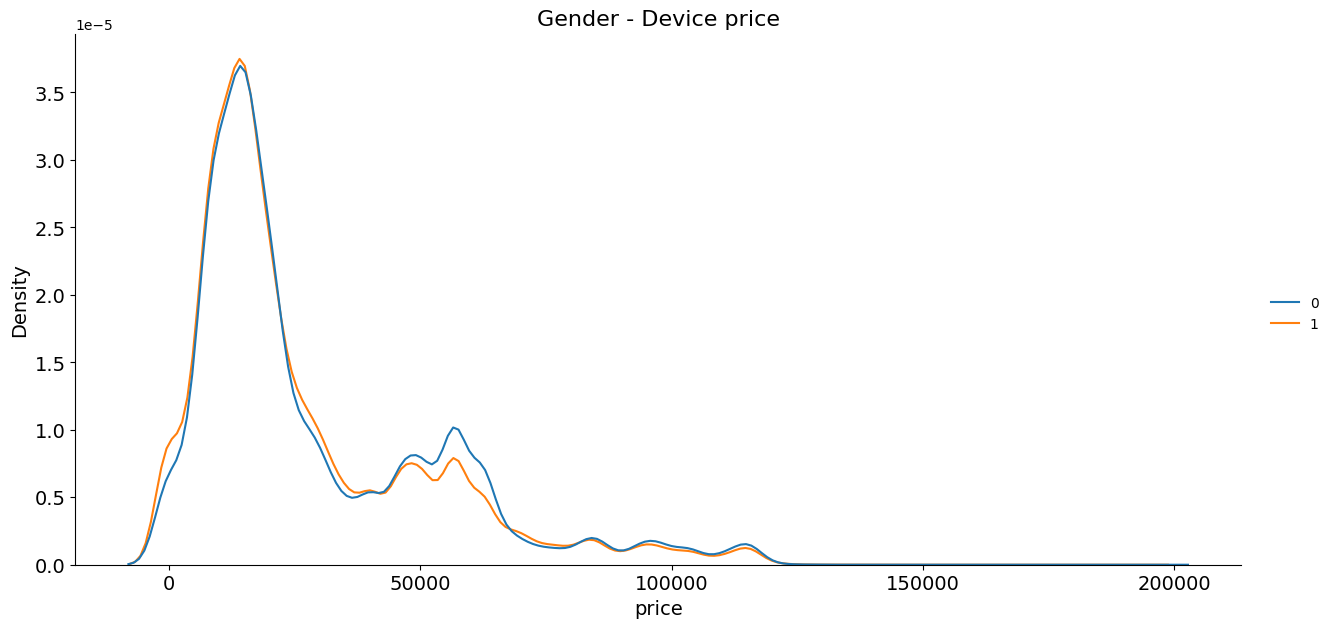

In [55]:
displot_category(train_data, 'is_male', 'price', 'Gender - Device price')

Вывод: в диапазоне цены девайса 50-70 тысяч небольшой перевес в пользу женщин, в остальном распределения очень похожи

## Гипотеза 4
Доля заходов в первую половину суток у женщин выше, доля во вторую половину выше у мужчин.

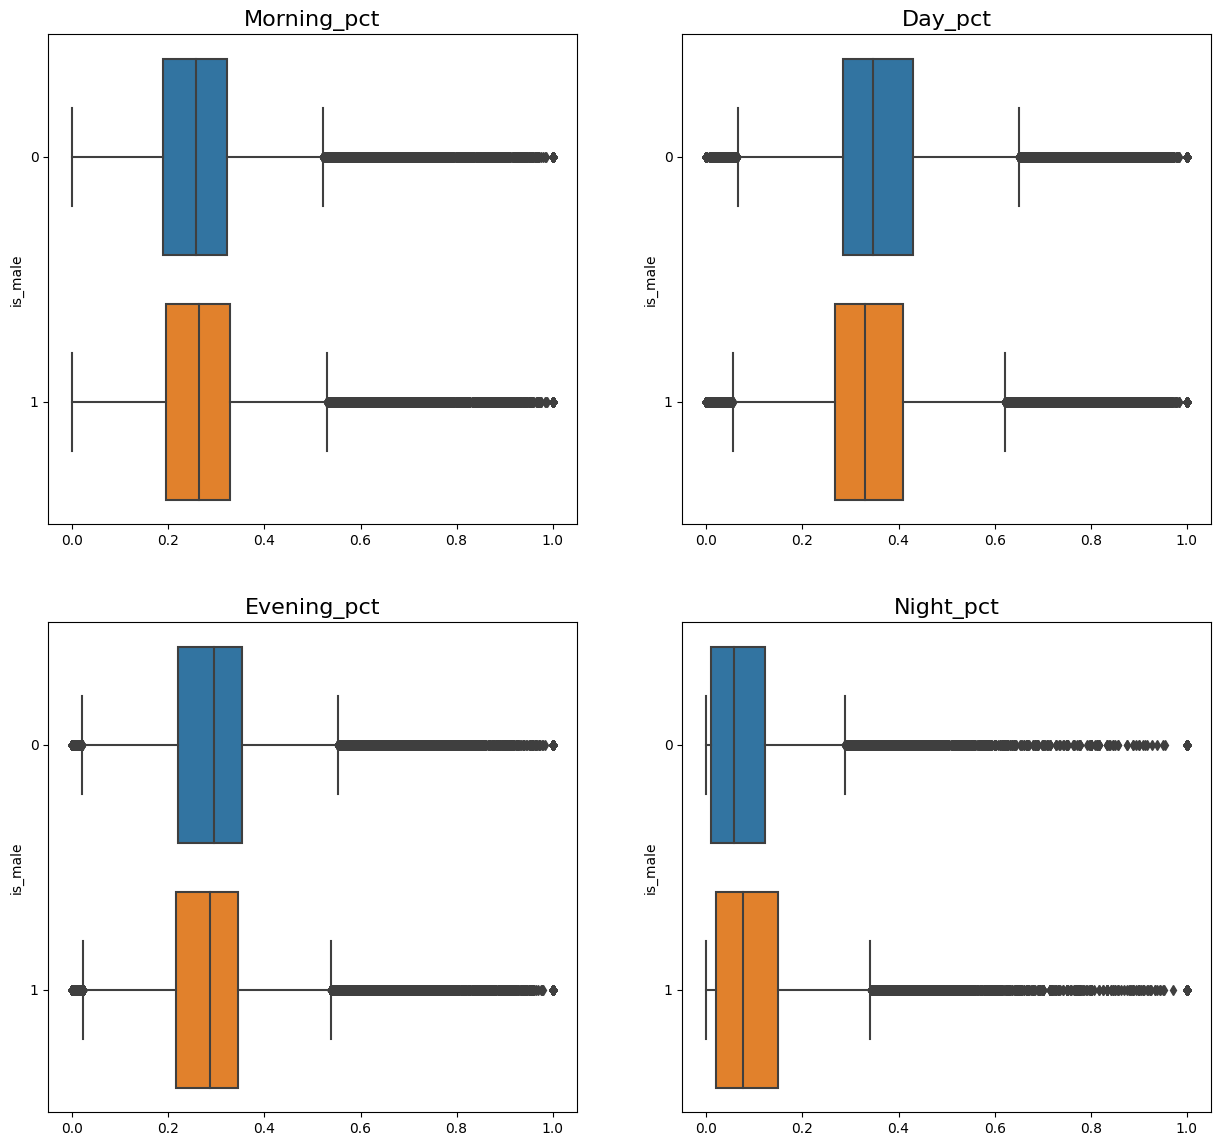

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 14))

graph1 = sns.boxplot(data=train_data,
                     x='morning_pct',
                     y='is_male',
                     orient='h',
                     ax=axes[0, 0])
axes[0, 0].set_title('Morning_pct', fontsize=16)
graph1.set(xlabel=None)

graph2 = sns.boxplot(data=train_data, x='day_pct', y='is_male', orient='h', ax=axes[0, 1])
axes[0, 1].set_title('Day_pct', fontsize=16)
graph2.set(xlabel=None)

graph3 = sns.boxplot(data=train_data,
                     x='evening_pct',
                     y='is_male',
                     orient='h',
                     ax=axes[1, 0])
axes[1, 0].set_title('Evening_pct', fontsize=16)
graph3.set(xlabel=None)

graph4 = sns.boxplot(data=train_data,
                     x='night_pct',
                     y='is_male',
                     orient='h',
                     ax=axes[1, 1])
axes[1, 1].set_title('Night_pct', fontsize=16)
graph4.set(xlabel=None)

plt.show()

Вывод: медианные значения доли заходов утром и ночью выше у мужчин, днем и вечером - у женщин

## Гипотеза 5
Мужчины чаще ездят по регионам и городам

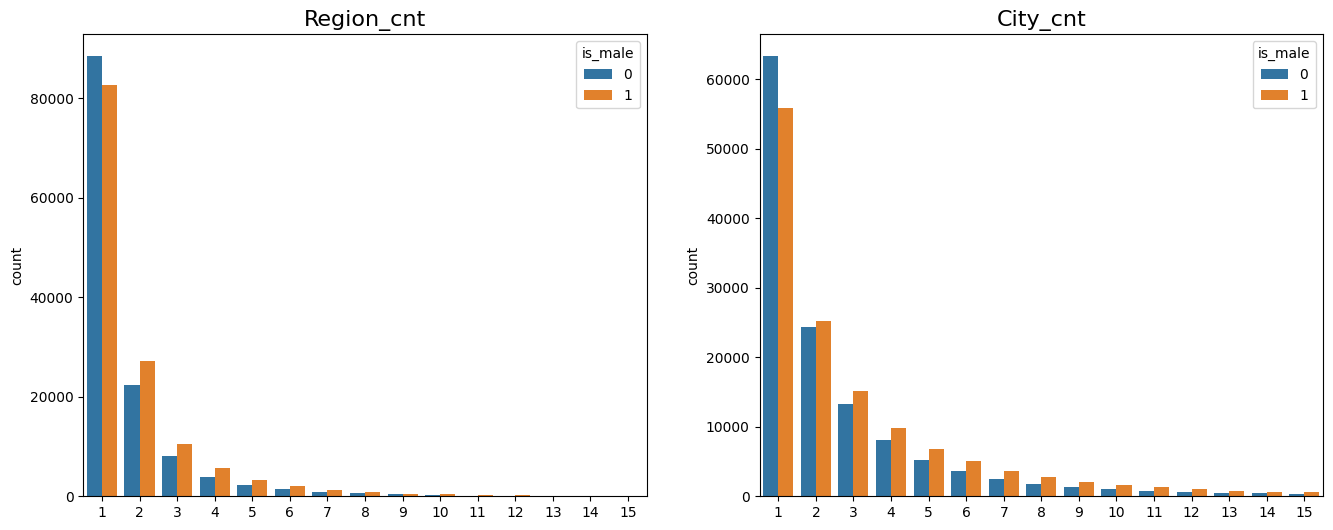

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

graph1 = sns.countplot(data=train_data.query('region_cnt <= 15'),
                       x='region_cnt',
                       hue='is_male',
                       ax=axes[0])
axes[0].set_title('Region_cnt', fontsize=16)
graph1.set(xlabel=None)

graph2 = sns.countplot(data=train_data.query('city_cnt <= 15'),
                       x='city_cnt',
                       hue='is_male',
                       ax=axes[1])
axes[1].set_title('City_cnt', fontsize=16)
graph2.set(xlabel=None)

plt.show()

Вывод: женщины чаще мужчин отправляют запросы только из 1 региона и города, в остальных случаях перевес в пользу мужчин

## Гипотеза 6
Женщины отправляют в среднем больше запросов в день, чем мужчины

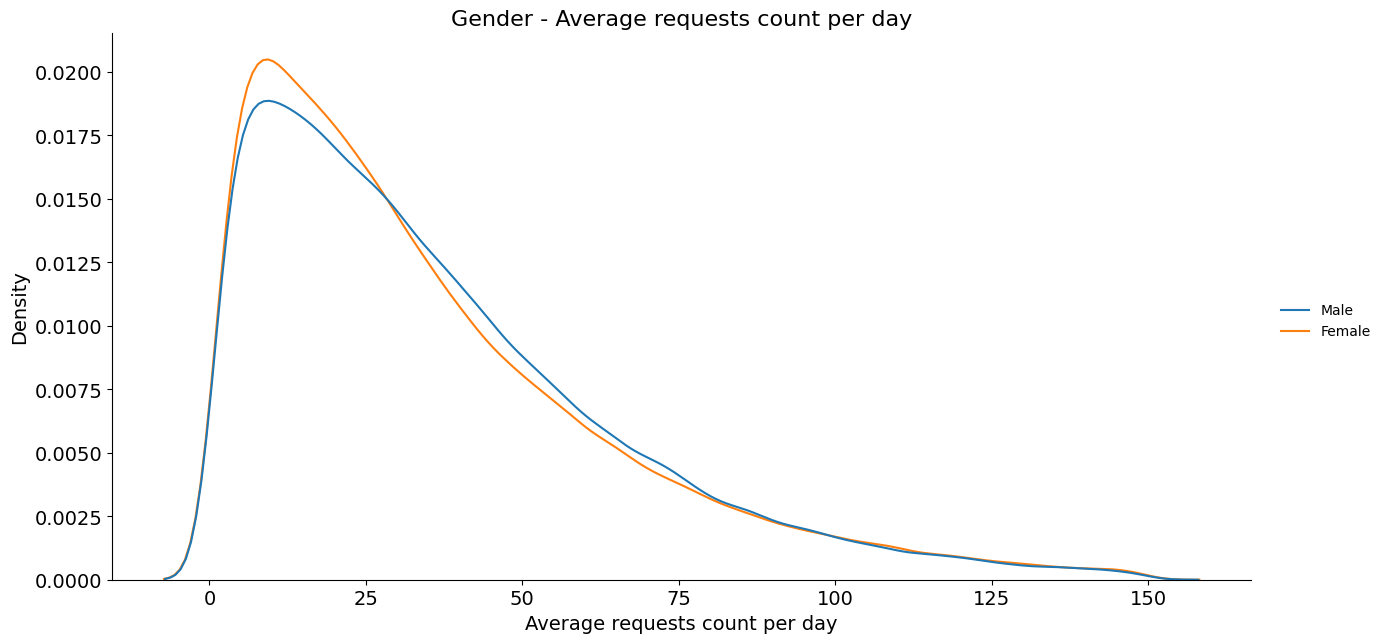

In [37]:
sns.displot(
    {
        "Male":
        train_data.query(
            'avg_req_per_day < 150 and is_male == 1').avg_req_per_day,
        "Female":
        train_data.query(
            'avg_req_per_day < 150 and is_male == 0').avg_req_per_day,
    },
    kind="kde",
    common_norm=False,
    height=6,
    aspect=2.1)

plt.title('Gender - Average requests count per day', fontsize=16)
plt.xlabel('Average requests count per day', fontsize=14)
plt.ylabel('Density', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Вывод: среди людей, которые отправляют запросы до 35 раз в день больше женщин, среди тех, кто отправил запрос от 35 до 80 раз - больше мужчин, дальше примерно равное соотношение

## Гипотеза 7
Женщины совершают визиты на большее число сайтов

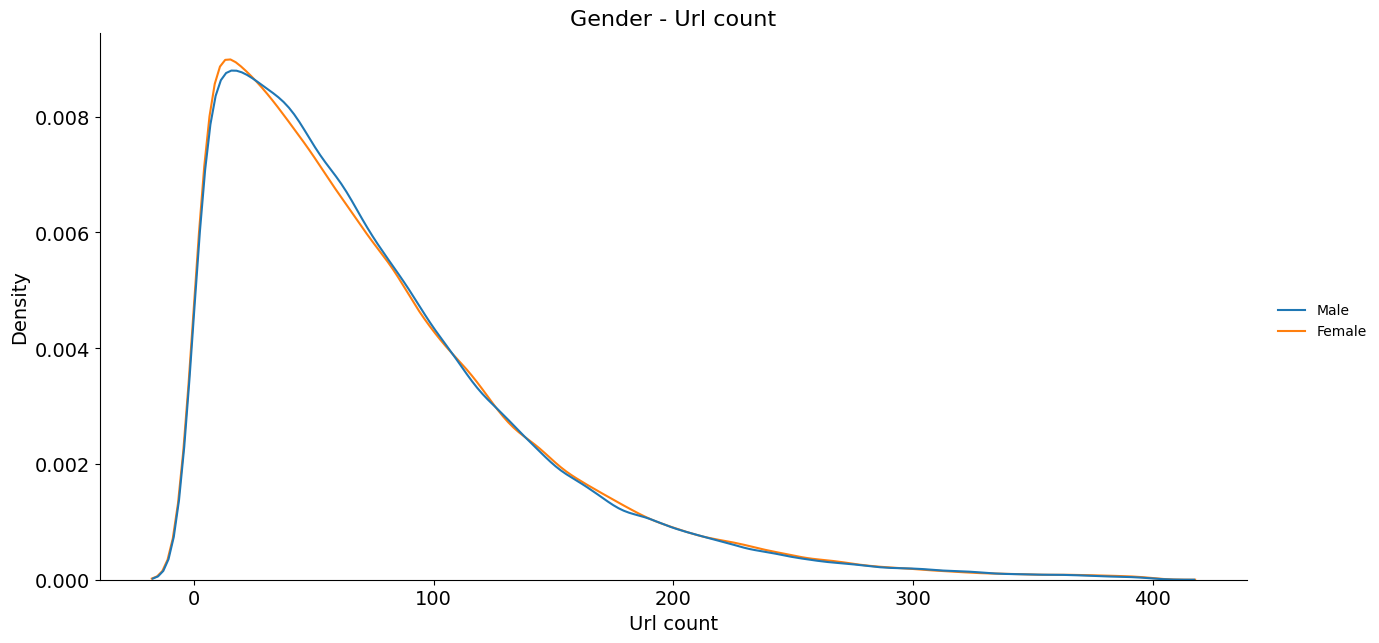

In [38]:
sns.displot(
    {
        "Male":
        train_data.query('url_host_cnt < 400 and is_male == 1').url_host_cnt,
        "Female":
        train_data.query('url_host_cnt < 400 and is_male == 0').url_host_cnt,
    },
    kind="kde",
    common_norm=False,
    height=6,
    aspect=2.1)

plt.title('Gender - Url count', fontsize=16)
plt.xlabel('Url count', fontsize=14)
plt.ylabel('Density', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Вывод: разницы в распределения почти нет, у женщин чуть чаще встречается кол-во сайтов до 50, у мужчин чуть чаще с 50 до 90

## Гипотеза 8
Процент активных дней у женщин выше

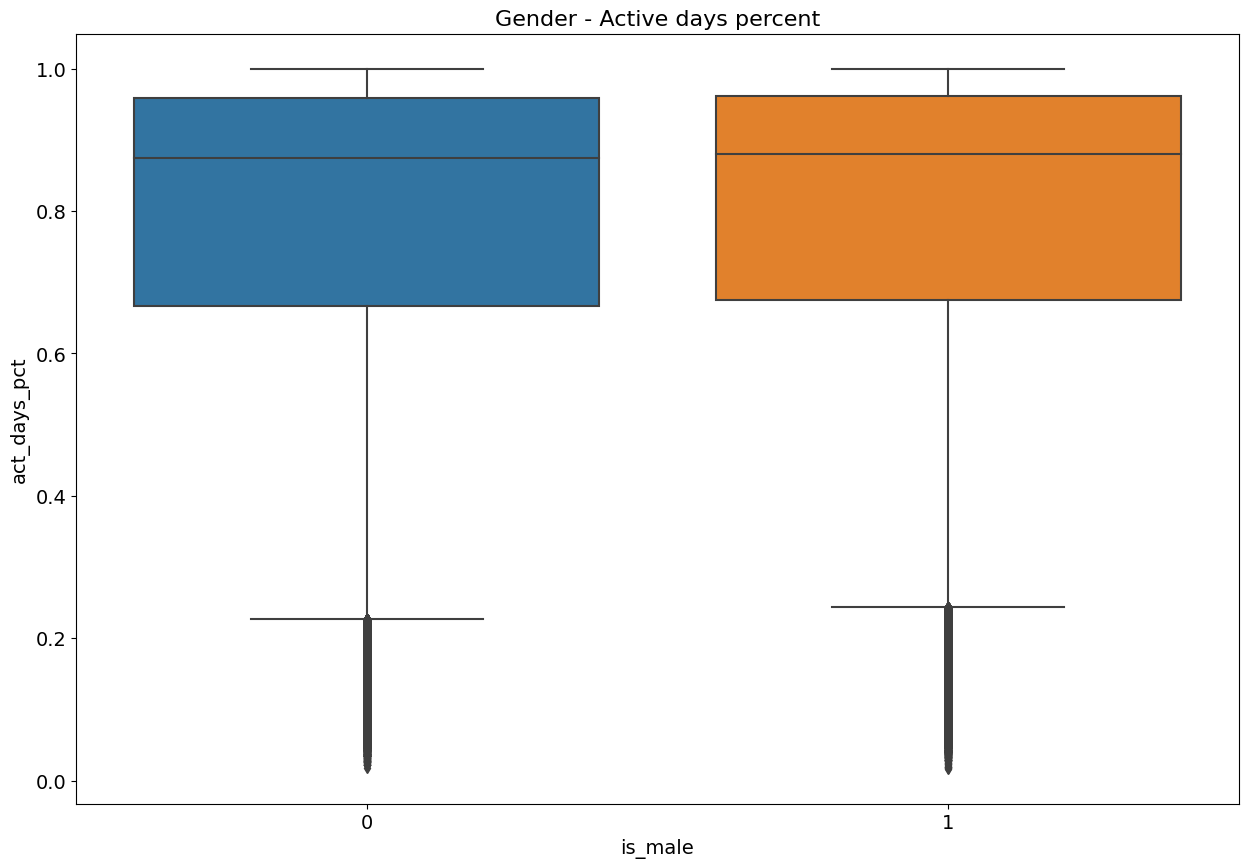

In [41]:
boxplot_category(train_data, 'is_male', 'act_days_pct', plot_title='Gender - Active days percent')

Вывод: разница между медианными значениями процента активных дней у мужчин и женщин минимальна

# Сохраним данные для обучения

In [44]:
config['train']['train_data_path']

'../data/processed/train_data.csv'

In [45]:
train_data.to_csv(config['train']['train_data_path'], index=False)